# Fogler P3-10C. Calculating Arrhenius Parameters
## An exploration of different methods for fitting data to known functional forms

In [1]:
#Standard start to almost all our Python code...
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#Import the raw data from the textbook
T_data = np.array([300.0, 320.0, 340.0, 360.0]) #T(K)
rate = np.array([0.002, 0.046, 0.72, 8.33]) #These data are -rA
A = 2.0 #M
B = 1.5 #M

We are told that the reaction is:

$$2A + B \rightarrow 4C$$

it is also (apparently) an **elementary** reaction, so the rate law must be:

$$-r_A = k_A[A]^2[B]$$

We use this to calculate k_A

In [3]:
k_data = rate/(A**2 * B)

# Linear regression from Arrhenius plot representation

Text(0.5, 1.0, 'Arrhenius Plot for P3-10C')

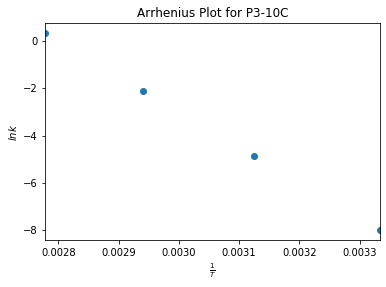

In [4]:
#For the Arrhenius relationship, we plot ln k vs 1/T 
X = 1/T_data
Y = np.log(k_data) #This is how we do natural logs in numpy
plt.scatter(X,Y)
plt.ylabel(r'$ln k$')
plt.xlabel(r'$\frac{1}{T}$') #LaTeX-like math expressions using Matplotlib's built-in mathtext environment
plt.xlim([min(X), max(X)])
plt.title('Arrhenius Plot for P3-10C')

r^2=  0.9999982867042083


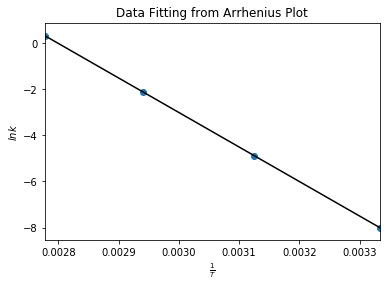

In [5]:
#Now that we have the linear transformation, we can simply calculate a line of best fit
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_error = linregress(X,Y)
X_plot = np.linspace(min(X),max(X),10)
Y_plot = slope*X_plot+intercept
plt.plot(X_plot,Y_plot, 'k')
plt.scatter(X,Y)
plt.ylabel(r'$ln k$')
plt.xlabel(r'$\frac{1}{T}$') #LaTeX-like math expressions using Matplotlib's built-in mathtext environment
plt.xlim([min(X), max(X)])
plt.title('Data Fitting from Arrhenius Plot')
print('r^2= ',r_value**2)

In [9]:
#We can now extract the activation energy from the slope of the plot
R = 8.314 #J/mol-K
E_act = slope * R / -1000.0
A = np.exp(intercept)
print('A = ', A)
print('E_act = ', E_act, ' kJ/mol')
print('p = ', p_value)
print('s = ', std_error)

A =  1.7300921230261624e+18
E_act =  124.70242975386347  kJ/mol
p =  8.566482627703309e-07
s =  13.88246041050032


# Nonlinear regression
## A better way (maybe)!
Since we're no longer using rulers to draw straight lines, there's no reason to transform the data before fitting it. We can use non-linear regression to get there instead. We will use the curve_fit function from scipy.optimize

In [7]:
#First define a function that takes T data, and spits out guesses for k, based on a parsed value for E_a and A
#NOTICE that the first argument to the function MUST be the independent data (e.g. x)
def arrhenius(T, E_a, A):
    k = A*np.exp(-1.0* E_a / (R * T))
    return k

In [8]:
from scipy.optimize import curve_fit

Now we use the least-squares method, curve_fit, to fit this function to the data we have. Mathematically, what's going on is the minimization of error between predicted values (calculated from a function we define) and the actual experimental data. If $\theta$ is the parameters to optimize, then $$\hat{\theta} = \underset{\theta}{\operatorname{argmin}} \sum_{i=1}^{n}\left(f_{\theta}(x_i)-y_i\right)^2 $$

Curve_fit takes a minimum of three arguments: 1) the function to optimize (in this case arrhenius), 2) the x data, 3) the y data. We will also be providing an optional fourth arugment, which represents an initial guess for the two parameters.

The curve_fit function has two outputs. The first, here popt is an array of the fitted parameters, in the order listed in the function being optimized. The second pcov describes some of the statistics around the fit, which we'll ignore for now but which will become useful later

In [11]:
popt, pcov = curve_fit(arrhenius, T_data, k_data, [124000, 1.7E18])
E_act_nln = popt[0] / 1000.0
A_nln = popt[1]
print(popt)

[1.24575421e+05 1.65412935e+18]


In [10]:
print('A = ', A_nln)
print('E_act = ', E_act_nln, ' kJ/mol')

A =  1.6541293466124925e+18
E_act =  124.5754207762676  kJ/mol


### Which one should I use?

Notice that in this example, the results are almost identical. This will not always be the case! In general, here are some things to consider when decidinng which approach to use:

* Transforming data into linear form can introduce error (especially when taking reciprocals of small numbers). We'll see examples of this when we study enzyme systems later in the course
* Using curve_fit requires an optimization algorithm. Generally speaking these solvers are great at finding **local** minima, but guaranteeting that you have found the **global** minimum is really hard. So, the quality of your parameters could depend on the initial guess you provide, especially for highly non-linear systems